In [73]:
import numpy as np
from numpy import ma
import pandas as pd
import math
from sklearn import metrics, linear_model
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import keras

import tensorflow as tf
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import os
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import average_precision_score, matthews_corrcoef
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support

# Import Data

In [74]:
print(os.getcwd())
relative_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
train_df = pd.read_csv(relative_path+'/preprocessed_data/full_dataset_train_test_val/full_train_df_feats.csv')

test_df = pd.read_csv(relative_path+'/preprocessed_data/full_dataset_train_test_val/full_test_df_feats.csv')

validation_df = pd.read_csv(relative_path+'/preprocessed_data/full_dataset_train_test_val/full_val_df_feats.csv')




a:\Desktop\FYP Final Files\notebooks\Unsupervised_ML


In [75]:
train_df.head()

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus,evil
0,1,0,0,1,157,5,0,1,0
1,1,0,0,1,3,1,0,1,0
2,1,0,0,1,1010,0,0,1,0
3,1,1,0,0,21,2,2,1,0
4,1,1,0,0,1005,4,0,1,0


# Helpers

In [76]:
def split_data(df: pd.DataFrame) -> pd.DataFrame:
    features = df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]]
    labels = df['sus']
    return features, labels

In [77]:
def print_metrics(y_true, y_predicted):

    accuracy = accuracy_score(y_true, y_predicted)   
    metrics_results = precision_recall_fscore_support(y_true, y_predicted, average="weighted", pos_label=1)
    average_precision = average_precision_score(y_true, y_predicted)
    balanced_accuracy = balanced_accuracy_score(y_true, y_predicted)
    mcc = matthews_corrcoef(y_true, y_predicted)
    
    print(f'Accuracy:\t{accuracy:.3f}')
    print(f'Precision:\t{metrics_results[0]}')
    print(f'Recall:\t\t{metrics_results[1]:.3f}')
    print(f'F1-Score:\t{metrics_results[2]:.3f}')
    print("Average Precision Score:", average_precision)
    print("Balanced Accuracy Score:", balanced_accuracy)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_true , y_predicted)))
    
    #make confusion matrix
    confusion_matrixs = confusion_matrix(y_true, y_predicted)
    

    TP = confusion_matrixs[1][1]
    TN = confusion_matrixs[0][0]
    FP = confusion_matrixs[0][1]
    FN = confusion_matrixs[1][0]


    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrixs, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

    # Print roc curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_predicted)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, )
    display.plot()
    plt.show()


    precision, recall, _ = precision_recall_curve(y_true, y_predicted)

    # Calculate the area under the curve
    pr_auc = auc(recall, precision)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

In [78]:
def normal_accuracy(values):
    
    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)
    
    return accuracy

def fraud_accuracy(values):
    
    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)
    
    return accuracy

In [79]:
def prepare_labels(y_predicted):
    """
    Helper function to help map out the outputs from models that return -1 for outliers and 1 for inliners.
    """
    y_predicted[y_predicted == 1] = 0
    y_predicted[y_predicted == -1] = 1
    return y_predicted

# Split data

In [80]:
train_df_feats, train_df_labels = split_data(train_df)
test_df_feats, test_df_labels = split_data(test_df)
val_df_feats, val_df_labels = split_data(validation_df)

In [81]:
train_df_feats.head()
train_df_feats.shape

(763144, 7)

In [82]:
train_df_labels.head()
train_df_labels.shape

(763144,)

In [83]:
train_df_feats.head()

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
0,1,0,0,1,157,5,0
1,1,0,0,1,3,1,0
2,1,0,0,1,1010,0,0
3,1,1,0,0,21,2,2
4,1,1,0,0,1005,4,0


# Model training

## Isolation forest

In [84]:
iforest = IsolationForest(random_state=0,contamination=0.05)
iforest.fit(train_df_feats)

IsolationForest(contamination=0.05, random_state=0)

In [85]:
ypred_iforest = iforest.predict(val_df_feats)
ypred_iforest = prepare_labels(ypred_iforest)
print(classification_report(val_df_labels, ypred_iforest,digits=3))

              precision    recall  f1-score   support

           0      0.998     0.938     0.967    188181
           1      0.040     0.615     0.075       786

    accuracy                          0.937    188967
   macro avg      0.519     0.776     0.521    188967
weighted avg      0.994     0.937     0.964    188967



Accuracy:	0.937
Precision:	0.9943014651630216
Recall:		0.937
F1-Score:	0.964
Average Precision Score: 0.02621213905128141
Balanced Accuracy Score: 0.7764889727126851
Matthews Correlation Coefficient (MCC): 0.145594184922168
AUC : 0.77649


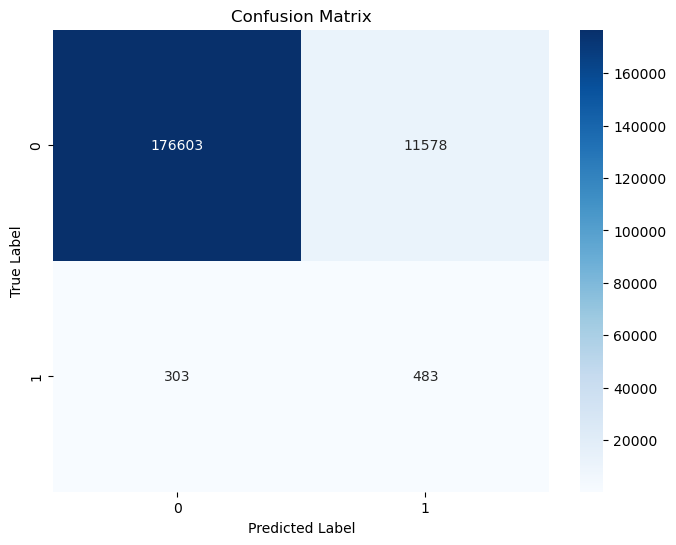

True Positives (TP): 483
True Negatives (TN): 176603
False Positives (FP): 11578
False Negatives (FN): 303


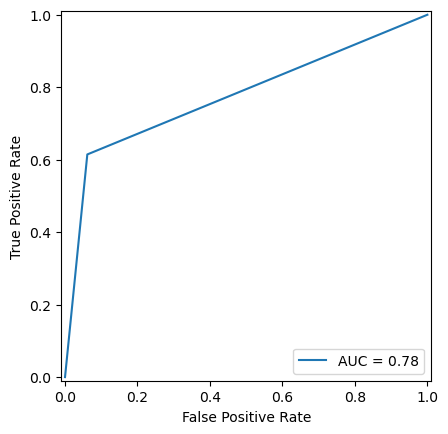

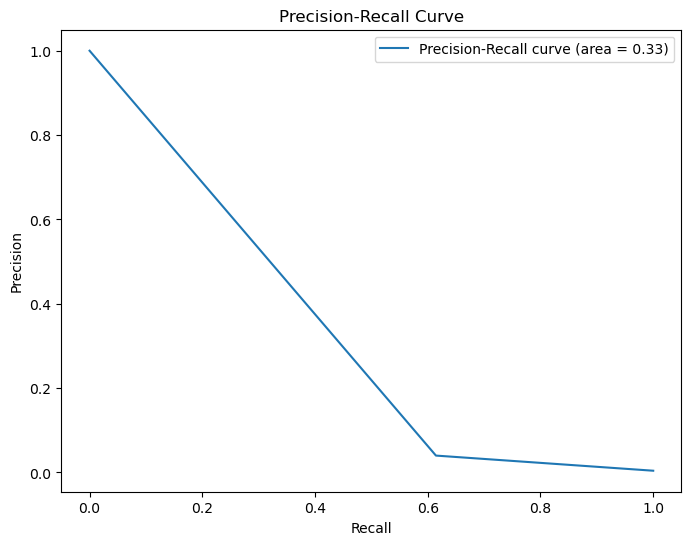

In [86]:
print_metrics(val_df_labels,ypred_iforest)

In [87]:
ypred_iforest_test = iforest.predict(test_df_feats)
ypred_iforest_test = prepare_labels(ypred_iforest_test)
print(classification_report(test_df_labels, ypred_iforest_test,digits=3))

              precision    recall  f1-score   support

           0      0.366     0.831     0.508     17508
           1      0.980     0.853     0.912    171459

    accuracy                          0.851    188967
   macro avg      0.673     0.842     0.710    188967
weighted avg      0.923     0.851     0.875    188967



Accuracy:	0.851
Precision:	0.9232889085875683
Recall:		0.851
F1-Score:	0.875
Average Precision Score: 0.9694784575994231
Balanced Accuracy Score: 0.8420700564255055
Matthews Correlation Coefficient (MCC): 0.4868037901374372
AUC : 0.84207


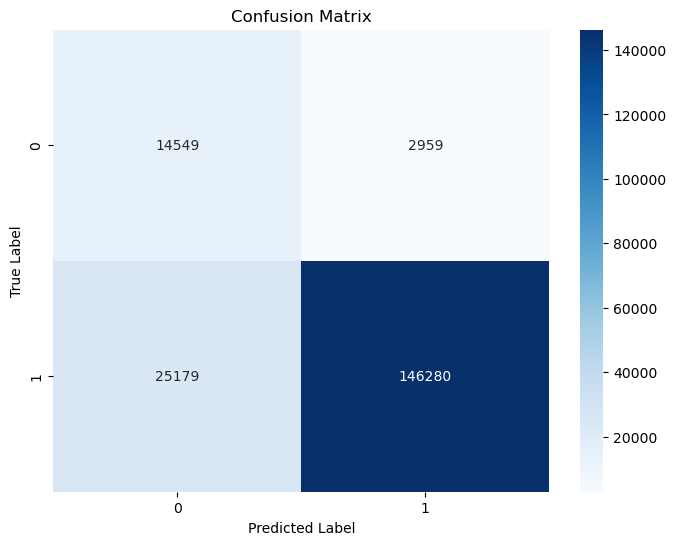

True Positives (TP): 146280
True Negatives (TN): 14549
False Positives (FP): 2959
False Negatives (FN): 25179


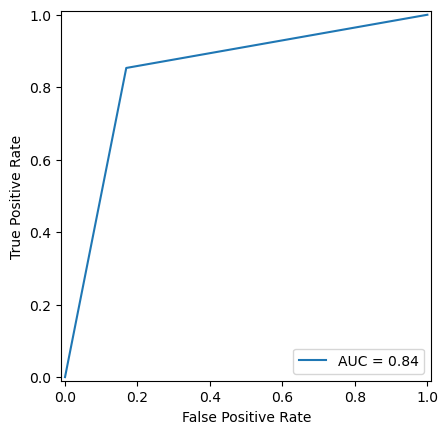

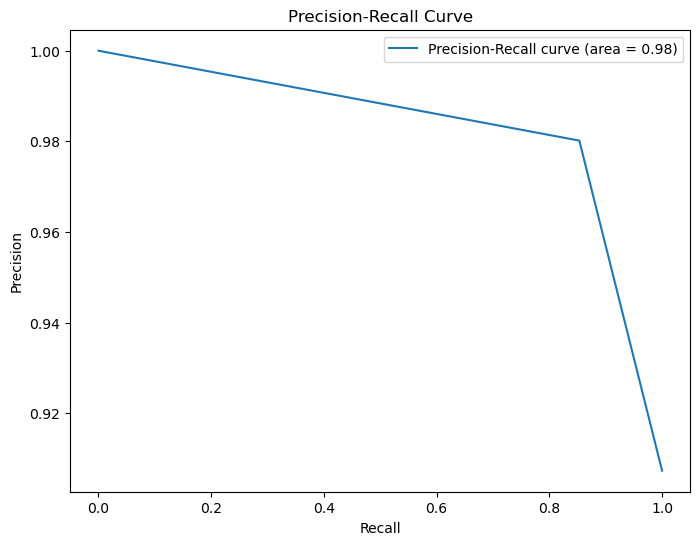

In [88]:
print_metrics(test_df_labels,ypred_iforest_test)

## Local Outlier Factor

In [89]:
lof = LocalOutlierFactor(contamination=0.05, novelty=True)
lof.fit(train_df_feats)

LocalOutlierFactor(contamination=0.05, novelty=True)

In [90]:
predicted_scores = lof.decision_function(test_df_feats)
predicted_labels = lof.predict(test_df_feats)
predicted_labels = (predicted_labels == -1).astype(int)

c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Accuracy:	0.927
Precision:	0.9582502063111997
Recall:		0.927
F1-Score:	0.935
Average Precision Score: 0.9916992318928121
Balanced Accuracy Score: 0.955651371638788
Matthews Correlation Coefficient (MCC): 0.7131077881752588
AUC : 0.95565


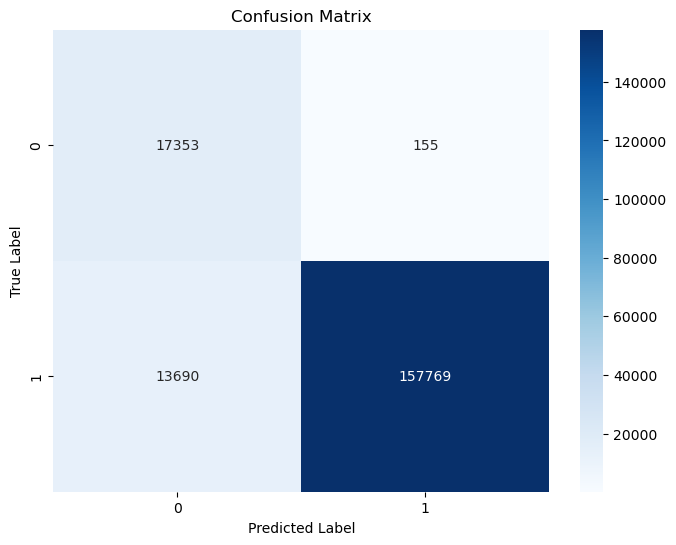

True Positives (TP): 157769
True Negatives (TN): 17353
False Positives (FP): 155
False Negatives (FN): 13690


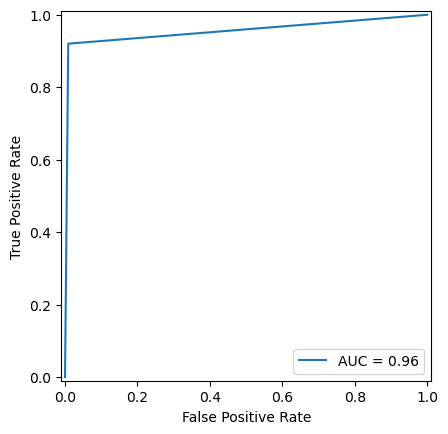

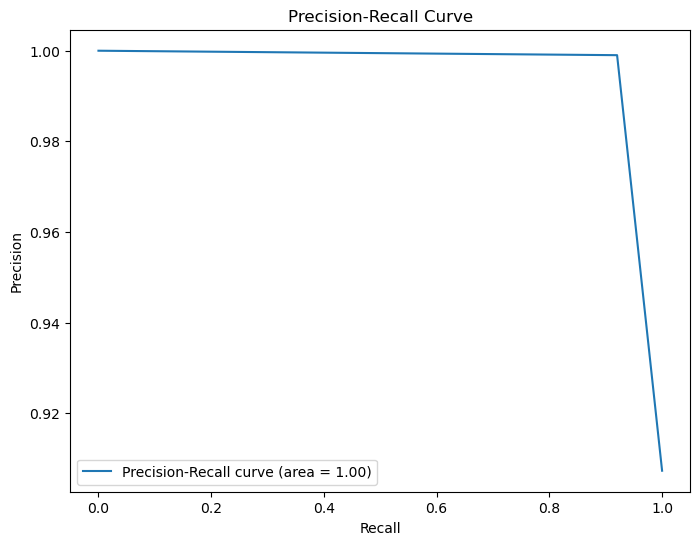

In [91]:
print_metrics(test_df_labels,predicted_labels)

In [92]:
predicted_scores = lof.decision_function(val_df_feats)
predicted_labels = lof.predict(val_df_feats)
predicted_labels = (predicted_labels == -1).astype(int)

c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Accuracy:	0.995
Precision:	0.9932628774480775
Recall:		0.995
F1-Score:	0.994
Average Precision Score: 0.025073256026960655
Balanced Accuracy Score: 0.5340296460558052
Matthews Correlation Coefficient (MCC): 0.14400440223312072
AUC : 0.53403


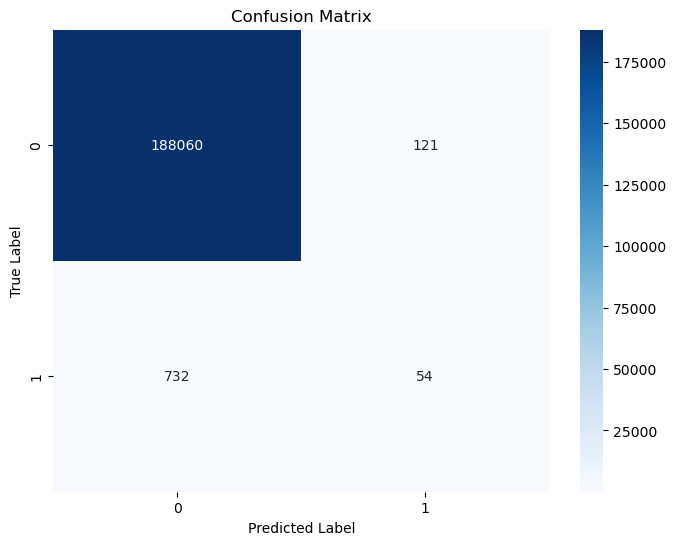

True Positives (TP): 54
True Negatives (TN): 188060
False Positives (FP): 121
False Negatives (FN): 732


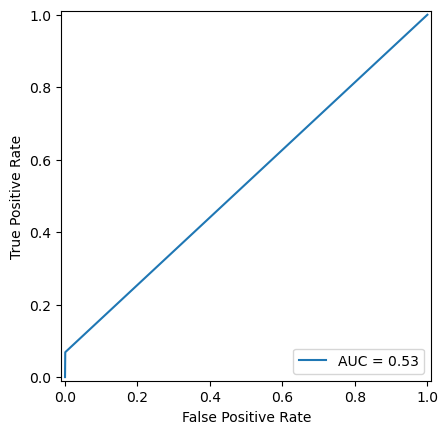

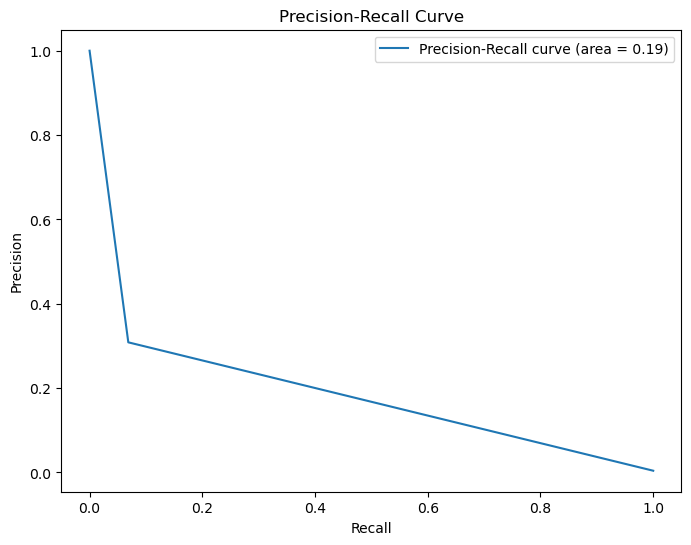

In [93]:
print_metrics(val_df_labels,predicted_labels)

## SVM

In [94]:
model = linear_model.SGDOneClassSVM(random_state=0).fit(train_df_feats)

Accuracy:	0.701
Precision:	0.9910823536166431
Recall:		0.701
F1-Score:	0.821
Average Precision Score: 0.0038757132719504897
Balanced Accuracy Score: 0.4464956306683946
Matthews Correlation Coefficient (MCC): -0.015084973443520134
AUC : 0.44650


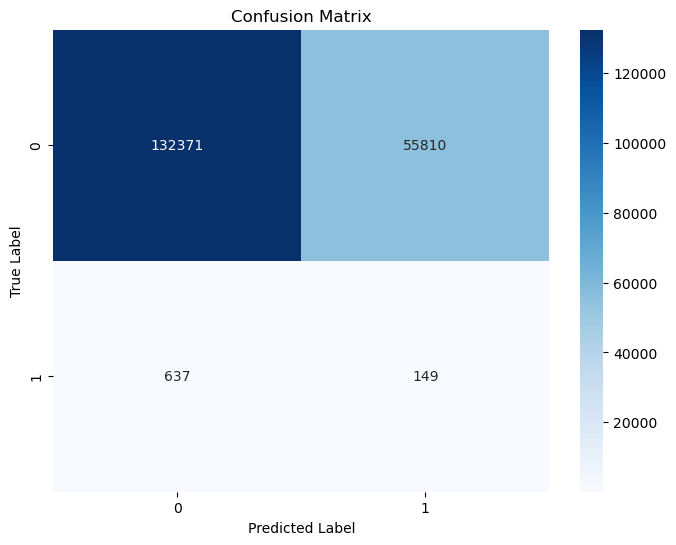

True Positives (TP): 149
True Negatives (TN): 132371
False Positives (FP): 55810
False Negatives (FN): 637


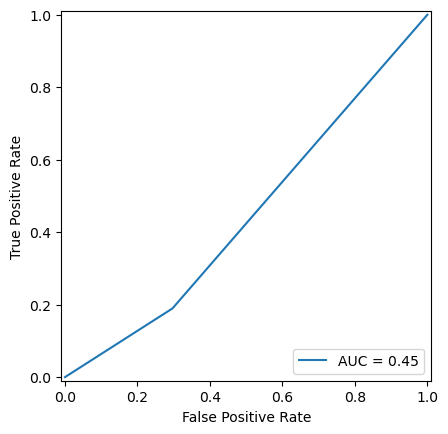

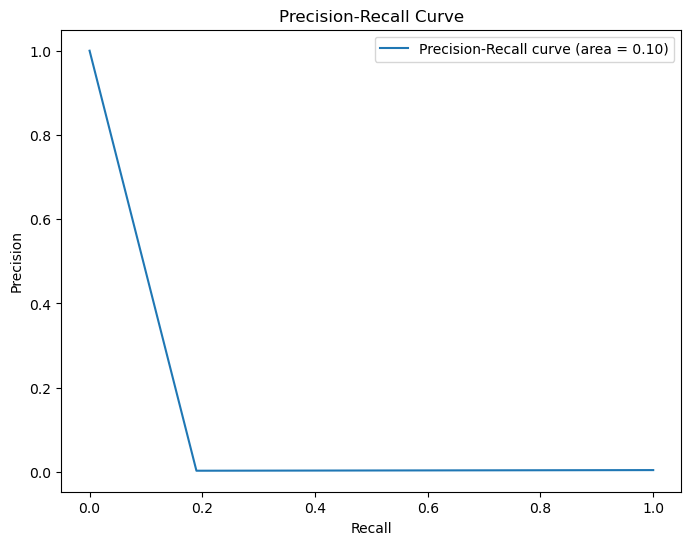

In [95]:
y_pred_svm_val = model.predict(val_df_feats)
y_pred_svm_val = prepare_labels(y_pred_svm_val)
print_metrics(val_df_labels,y_pred_svm_val)

Accuracy:	0.105
Precision:	0.5545655096019705
Recall:		0.105
F1-Score:	0.078
Average Precision Score: 0.8956140810884428
Balanced Accuracy Score: 0.39509056353714944
Matthews Correlation Coefficient (MCC): -0.26010006220217413
AUC : 0.39509


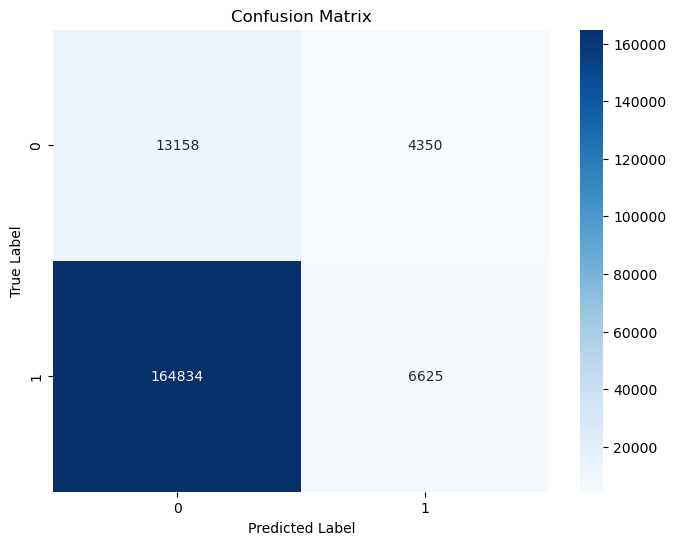

True Positives (TP): 6625
True Negatives (TN): 13158
False Positives (FP): 4350
False Negatives (FN): 164834


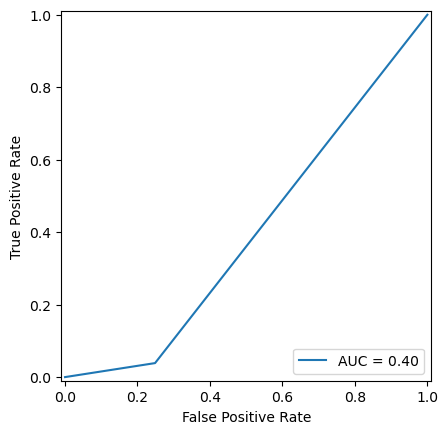

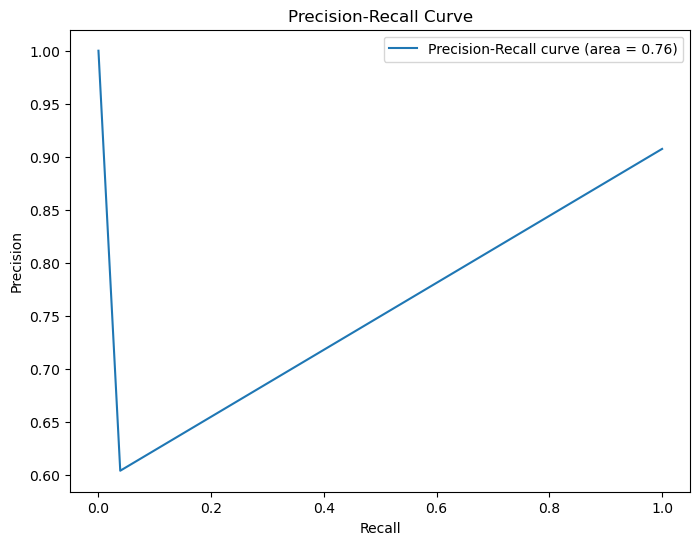

In [96]:
y_pred_svm_test = model.predict(test_df_feats)
y_pred_svm_test = prepare_labels(y_pred_svm_test)
print_metrics(test_df_labels,y_pred_svm_test)

## Autoenconder

In [97]:
input_dim = train_df_feats.shape[1] # Number of features

In [98]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

input_dim = train_df_feats.shape[1] # Number of features

# Encoder
input_layer = Input(shape=(input_dim, ))
encoder = Dense(128, activation="relu")(input_layer)
encoder = Dense(64, activation="relu")(encoder)

# Bottleneck
bottleneck = Dense(32, activation="relu")(encoder)

# Decoder
decoder = Dense(64, activation="relu")(bottleneck)
decoder = Dense(128, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [99]:
checkpoint = ModelCheckpoint("best_weights4.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = autoencoder.fit(
    train_df_feats, train_df_feats,
    epochs=20,
    batch_size=256,
    validation_data=(val_df_feats, val_df_feats),
    shuffle=True,
    callbacks=[checkpoint]
)
autoencoder.load_weights("best_weights4.keras")

Epoch 1/20
2957/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 750.1701
Epoch 1: val_loss improved from inf to 0.02125, saving model to best_weights4.keras
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 744.6445 - val_loss: 0.0213
Epoch 2/20
2966/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0682
Epoch 2: val_loss did not improve from 0.02125
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0687 - val_loss: 0.0486
Epoch 3/20
2973/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4442
Epoch 3: val_loss did not improve from 0.02125
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4446 - val_loss: 0.0246
Epoch 4/20
2965/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1784
Epoch 4: val_loss did not improve from 0.02125
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1790 - val_loss: 0.1683
Epoch 5/20
2958/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3938
Epoch 5: val_loss improved from 0.02125 to 0.00439, saving model to best_weights4.keras
2982/2982 ━━━━━━━━━━━━━━━━━━━━

In [100]:
# Predict on the test set
X_test_pred = autoencoder.predict(test_df_feats)
# Predict on the val set
X_val_pred = autoencoder.predict(val_df_feats)

X_train_pred = autoencoder.predict(train_df_feats)

5906/5906 ━━━━━━━━━━━━━━━━━━━━ 6s 995us/step
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
23849/23849 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step


In [101]:
mse_train = np.mean(np.power(train_df_feats - X_train_pred, 2), axis=1)
mse_test = np.mean(np.power(test_df_feats - X_test_pred, 2), axis=1)
mse_val = np.mean(np.power(val_df_feats - X_val_pred, 2), axis=1)

In [102]:

threshold = np.quantile(mse_train, 0.99)

# Predict anomalies on the test set
y_pred_test = (mse_test > threshold)
y_pred_test = y_pred_test.astype(int)

In [103]:
y_pred_val = (mse_val > threshold)
y_pred_val = y_pred_val.astype(int)

In [104]:
from sklearn.metrics import classification_report, roc_auc_score

# Calculate classification metrics
print(classification_report(test_df_labels, y_pred_test))

# Calculate AUC-ROC
roc_auc = roc_auc_score(test_df_labels, y_pred_test) # Using raw MSE scores for AUC calculation
print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       0.57      0.95      0.71     17508
           1       0.99      0.93      0.96    171459

    accuracy                           0.93    188967
   macro avg       0.78      0.94      0.83    188967
weighted avg       0.95      0.93      0.94    188967

AUC-ROC: 0.94


Accuracy:	0.928
Precision:	0.954824883448051
Recall:		0.928
F1-Score:	0.936
Average Precision Score: 0.9880985203116773
Balanced Accuracy Score: 0.9381293817662878
Matthews Correlation Coefficient (MCC): 0.7003264122990488
AUC : 0.93813


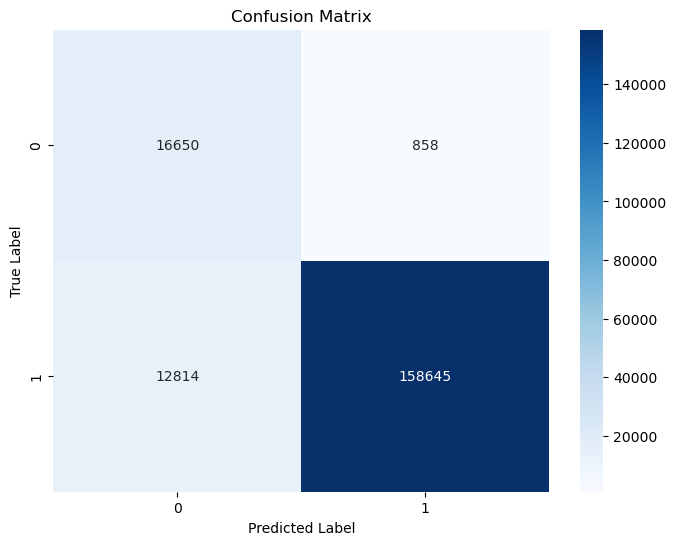

True Positives (TP): 158645
True Negatives (TN): 16650
False Positives (FP): 858
False Negatives (FN): 12814


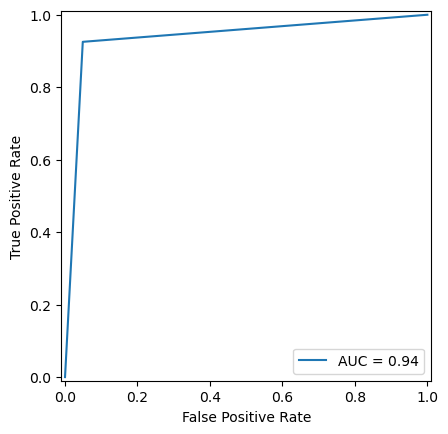

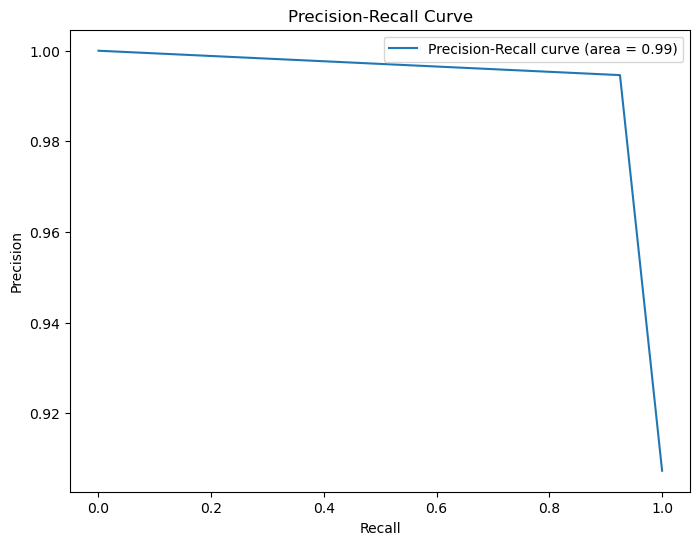

In [105]:
print_metrics(test_df_labels,y_pred_test)

In [106]:
from sklearn.metrics import classification_report, roc_auc_score

# Calculate classification metrics
print(classification_report(val_df_labels, y_pred_val))

# Calculate AUC-ROC
roc_auc = roc_auc_score(val_df_labels, y_pred_val) # Using raw MSE scores for AUC calculation
print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    188181
           1       0.14      0.42      0.21       786

    accuracy                           0.99    188967
   macro avg       0.57      0.71      0.60    188967
weighted avg       0.99      0.99      0.99    188967

AUC-ROC: 0.71


Accuracy:	0.987
Precision:	0.9940206227643416
Recall:		0.987
F1-Score:	0.990
Average Precision Score: 0.06320765459760913
Balanced Accuracy Score: 0.7065525695153574
Matthews Correlation Coefficient (MCC): 0.24143779565817666
AUC : 0.70655


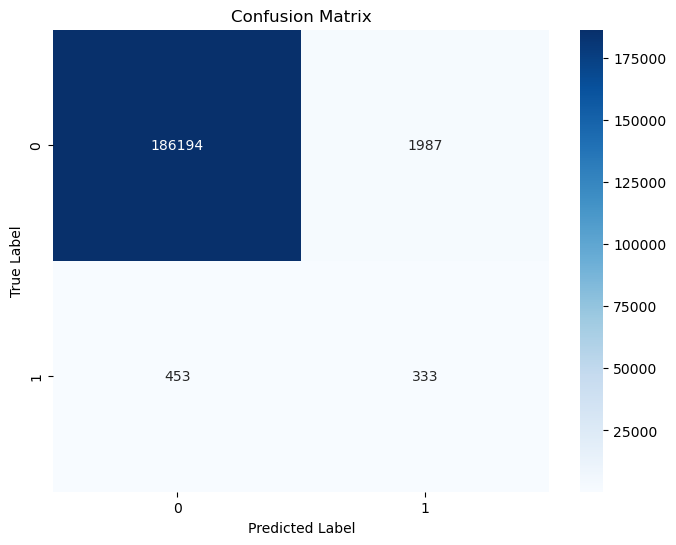

True Positives (TP): 333
True Negatives (TN): 186194
False Positives (FP): 1987
False Negatives (FN): 453


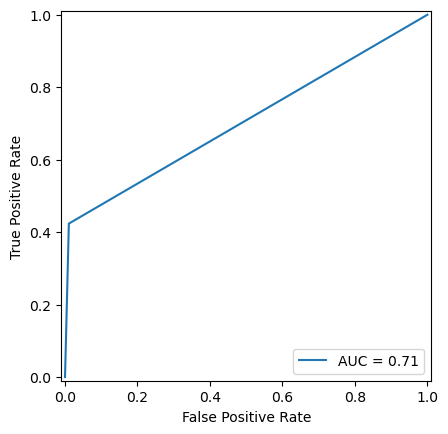

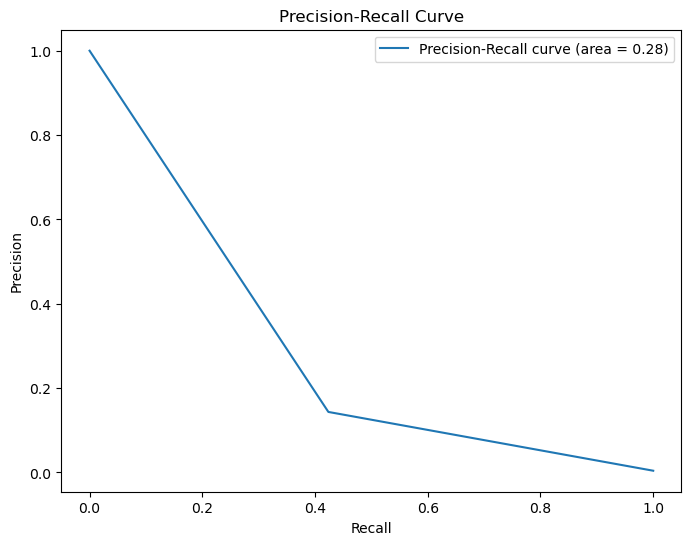

In [107]:
print_metrics(val_df_labels,y_pred_val)